# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [6]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import os

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2022 from the CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [8]:
year = "2022"
years = [2022]

# Ensure the directory exists
os.makedirs(f"models/{year}", exist_ok=True)

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 294515


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [10]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
203414,20220908021212PD,9237777,9/8/2022 12:00:00 AM,P222510029,2,9/8/2022 12:00:00 AM,9/8/2022 12:00:00 AM,00:50:30,SUSCIR,SUSPICIOUS CIRCUMSTANCES,R,Report taken,PEDRO ST & LINCOLN AV,San Jose,CA,37.315934,-121.908688,O'Connor Park
233535,20221013141149PD,9284828,10/13/2022 12:00:00 AM,P222860533,2,10/13/2022 12:00:00 AM,10/13/2022 12:00:00 AM,13:54:04,911UNK,UNK TYPE 911 CALL,CAN,Canceled,[800]-[900] S 1ST ST,San Jose,CA,37.316845,-121.874256,Spartan Keyes and Wool Creek
267973,20221125154416PS,9338663,11/25/2022 12:00:00 AM,P223290335,3,11/25/2022 12:00:00 AM,11/25/2022 12:00:00 AM,12:32:07,1066,SUSPICIOUS PERSON,N,No report required; dispatch record only,[5500]-[5600] LEXINGTON AV,San Jose,CA,37.251346,-121.798757,Village Oaks
8626,20220113003252PS,8927725,1/12/2022 12:00:00 AM,P220120874,3,1/12/2022 12:00:00 AM,1/12/2022 12:00:00 AM,23:06:48,415,DISTURBANCE,N,No report required; dispatch record only,[2000]-[2100] LITTLE ORCHARD ST,San Jose,CA,37.308502,-121.875092,Alma
192913,20220827231550PD,9222401,8/27/2022 12:00:00 AM,P222390845,4,8/27/2022 12:00:00 AM,8/27/2022 12:00:00 AM,20:57:16,415M,"DISTURBANCE, MUSIC",N,No report required; dispatch record only,[1000]-[1100] FLEETWOOD DR,San Jose,CA,37.229819,-121.867914,Almaden Lake


In [11]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294515 entries, 0 to 294514
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              294515 non-null  object 
 1   EID               294515 non-null  int64  
 2   START_DATE        294515 non-null  object 
 3   CALL_NUMBER       294515 non-null  object 
 4   PRIORITY          294515 non-null  int64  
 5   REPORT_DATE       294515 non-null  object 
 6   OFFENSE_DATE      294515 non-null  object 
 7   OFFENSE_TIME      294515 non-null  object 
 8   CALLTYPE_CODE     294515 non-null  object 
 9   CALL_TYPE         294515 non-null  object 
 10  FINAL_DISPO_CODE  294515 non-null  object 
 11  FINAL_DISPO       294515 non-null  object 
 12  ADDRESS           285666 non-null  object 
 13  CITY              294515 non-null  object 
 14  STATE             294515 non-null  object 
 15  LATITUDE          263943 non-null  float64
 16  LONGITUDE         26

In [12]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,2.945150e+05,294515.000000,263943.000000,263943.000000
mean,9.147900e+06,3.326116,37.323273,-121.872311
std,1.350881e+05,1.450309,0.042400,0.047365
min,8.912988e+06,1.000000,37.150332,-122.035696
25%,9.031842e+06,2.000000,37.300913,-121.903248
50%,9.145938e+06,3.000000,37.325810,-121.870243
75%,9.264946e+06,4.000000,37.349607,-121.840061
max,9.383082e+06,6.000000,37.534539,-121.684849


In [13]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,294515,294515,294515,294515,294515,294515,294515,294515,294515,294515,285666,294515,294515,262717
unique,292604,339,287596,359,359,80565,206,200,22,18,29750,1,1,295
top,20221204123543PS,3/7/2022 12:00:00 AM,P223340344,5/7/2022 12:00:00 AM,5/7/2022 12:00:00 AM,22:00:05,1195,VEHICLE STOP,N,No report required; dispatch record only,[1700]-[1800] AIRPORT BL,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,5877,7,1081,1081,17,37677,37677,138290,138290,1426,294515,294515,8465


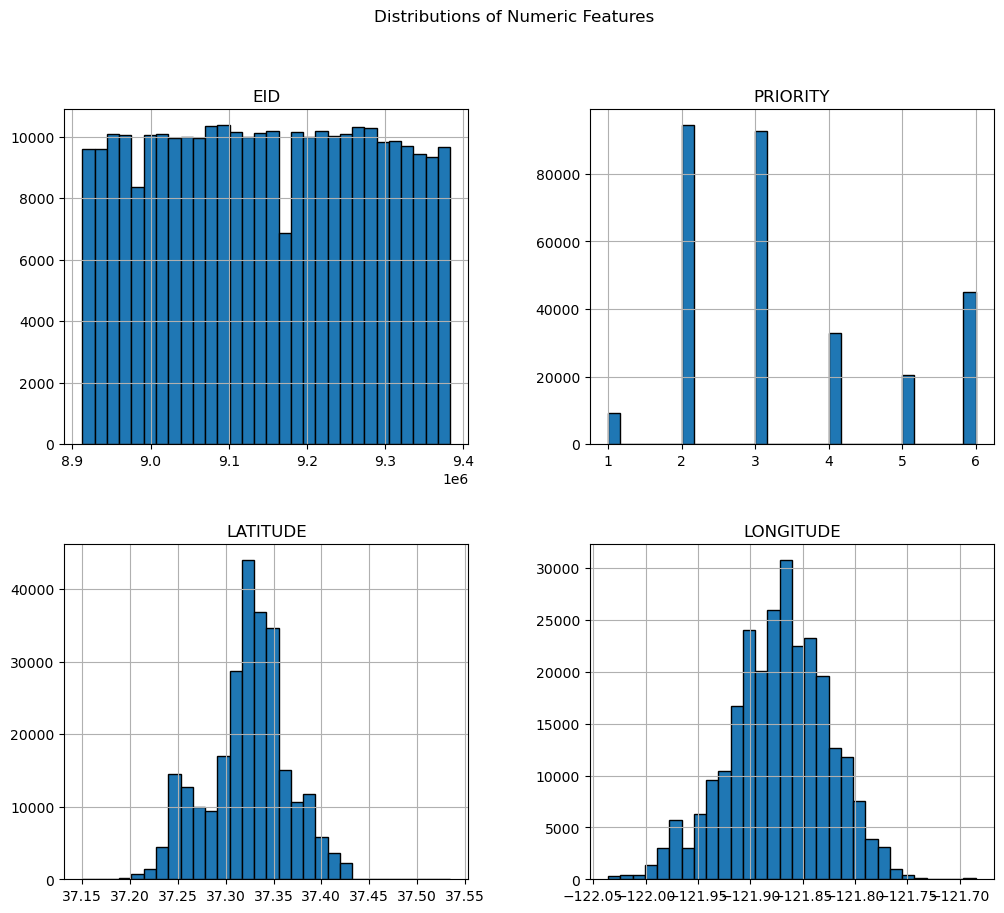

In [14]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [15]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              8849
CITY                    0
STATE                   0
LATITUDE            30572
LONGITUDE           30572
neighborhood        31798
dtype: int64

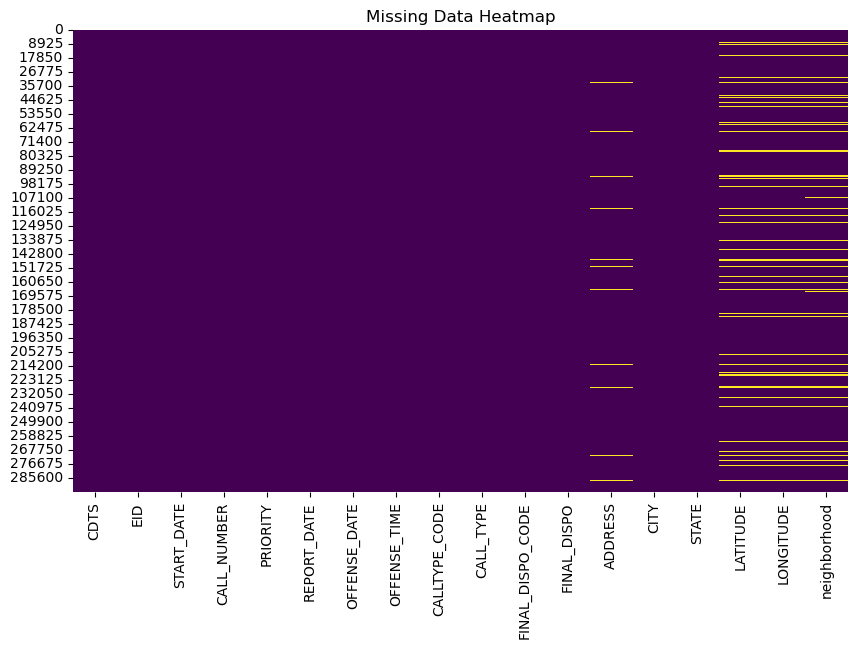

In [16]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [18]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 292604 unique values
START_DATE: 339 unique values
CALL_NUMBER: 287596 unique values
REPORT_DATE: 359 unique values
OFFENSE_DATE: 359 unique values
OFFENSE_TIME: 80565 unique values
CALLTYPE_CODE: 206 unique values
CALL_TYPE: 200 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 29750 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [19]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8465
Little Saigon and Spring Brook    4854
Trimble Business Area             4451
Five Wounds-San Jose High         4108
Alameda                           3595
                                  ... 
Los Alamitos Creek                  38
Linda Vista and Hillcrest           34
Meadowlands                         32
Alta Vista                          22
Santa Teresa Hills                  14
Name: count, Length: 295, dtype: int64

In [23]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          138290
CAN         52022
R           33213
G           14722
D            9999
E            6254
O            5798
GD           5326
DUPNCAN      4931
A            4435
U            3956
H            3056
T            2787
ADV          2696
C            2270
B            2091
NR           1813
F             723
Z              51
M              38
P              35
TOT             9
Name: count, dtype: int64

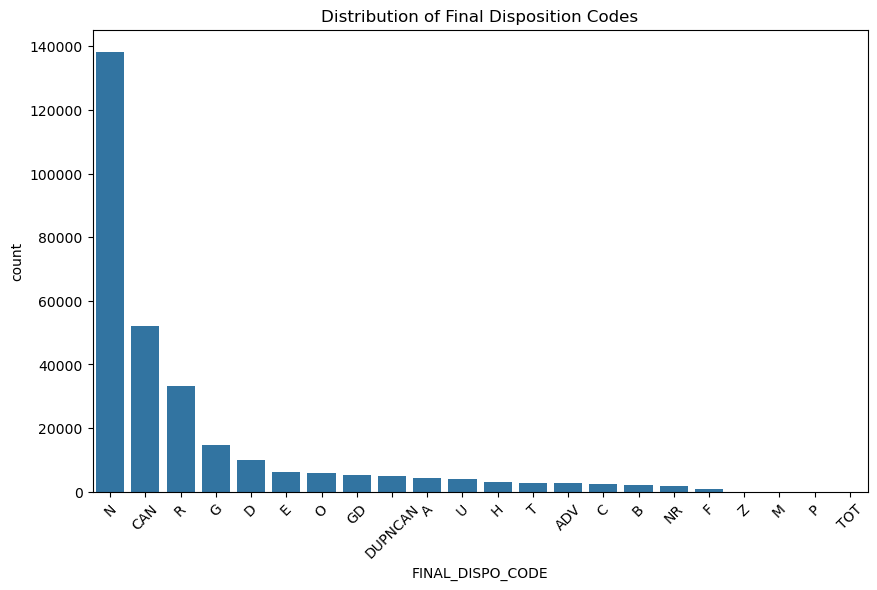

In [25]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [27]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch record only            138290
Canceled                                             52022
Report taken                                         33213
Gone on Arrival/unable to locate                     14722
No Disposition                                       13013
Traffic Citation Issued, Hazardous Violation          9999
Traffic Citation Issued, Non-Hazardous Violation      6254
Supplemental report taken                             5798
Arrest Made                                           4435
Unfounded event                                       3956
Courtesy Service/Citizen or agency assist             3056
Turned over To (TOT)                                  2787
Criminal Citation                                     2270
Arrest by Warrant                                     2091
No Response                                           1813
Field Interview (F.I.) Completed                       723
Stranded motorist assist                    

In [28]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch record only',
 'CAN': 'Canceled',
 'A': 'Arrest Made',
 'GD': 'No Disposition',
 'T': 'Turned over To (TOT)',
 'NR': 'No Response',
 'G': 'Gone on Arrival/unable to locate',
 'R': 'Report taken',
 'DUPNCAN': 'No Disposition',
 'D': 'Traffic Citation Issued, Hazardous Violation',
 'U': 'Unfounded event',
 'H': 'Courtesy Service/Citizen or agency assist',
 'E': 'Traffic Citation Issued, Non-Hazardous Violation',
 'O': 'Supplemental report taken',
 'B': 'Arrest by Warrant',
 'ADV': 'No Disposition',
 'F': 'Field Interview (F.I.) Completed',
 'C': 'Criminal Citation',
 'P': 'Prior case, follow-up activity only',
 'M': 'Stranded motorist assist',
 'Z': 'No Disposition',
 'TOT': 'No Disposition'}

In [30]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1066': 'SUSPICIOUS PERSON',
 '415': 'DISTURBANCE',
 '911UNK': 'UNK TYPE 911 CALL',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '11300': 'NARCOTICS',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1057': 'FIREARMS DISCHARGED',
 '1095': 'PEDESTRIAN STOP',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 'AID': 'PUBLIC SAFETY ASSISTANCE',
 '1033A': 'ALARM, AUDIBLE',
 '415M': 'DISTURBANCE, MUSIC',
 '1070': 'PROWLER',
 'WELCK': 'WELFARE CHECK',
 '1033S': 'ALARM, SILENT',
 '23103': 'RECKLESS DRIVING',
 '1066W': 'SUSPICIOUS PERSON W/ WEAPON',
 '5150': 'MENTALLY DISTURBED PERSON',
 '242': 'BATTERY',
 '417': 'BRANDISHING A WEAPON',
 '22500': 'PARKING VIOLATION',
 '1195': 'VEHICLE STOP',
 '1154': 'SUSPICIOUS VEHICLE',
 '415F': 'DISTURBANCE, FAMILY',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '484': 'THEFT',
 '415A': 'DISTURBANCE, FIGHT',
 '10851': 'STOLEN VEHICLE',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAMAGE',
 '10851R': 'RECOVERED STOLEN VEHICLE',
 '12025': 'CARRYING A CONCEALED WEAPON',
 'FNDPRP': 'FOUND PR

## Focus on Target Dispositions

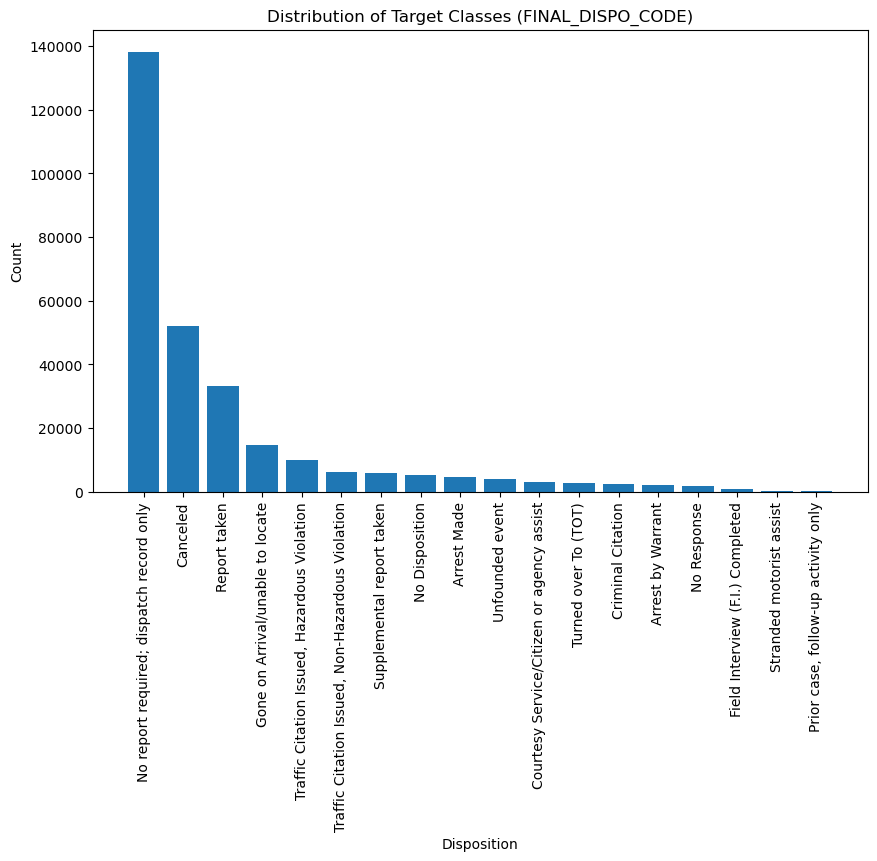

In [33]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [34]:
model_utils.transform_offense_date(all_police_df)

In [35]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    285719
A          4435
C          2270
B          2091
Name: count, dtype: int64

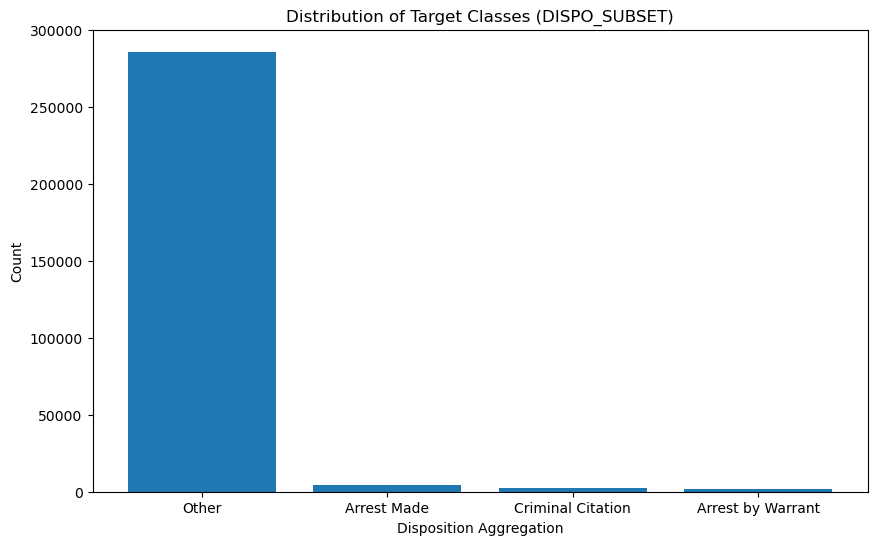

In [36]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [38]:
encoder = joblib.load('one_hot_encoder.pkl')

In [39]:
police_calls_encoded, _ = model_utils.clean_and_transform_data(all_police_df, encoder)
police_calls_encoded.shape

Police Calls Dataset: 294515 rows before cleaning, 262717 rows after cleaning.


(262717, 535)

## Define X and Y

In [41]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(210173, 534)
(52544, 534)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 203759, 0: 3254, 2: 1622, 1: 1538})
Counter({3: 6414, 0: 3254, 2: 1622, 1: 1538})


y_train distribution: Counter({3: 203759, 0: 3254, 2: 1622, 1: 1538})
y_test distribution: Counter({3: 50941, 0: 813, 2: 406, 1: 384})
y_train_resampled distribution: Counter({3: 203759, 0: 3254, 2: 1622, 1: 1538})


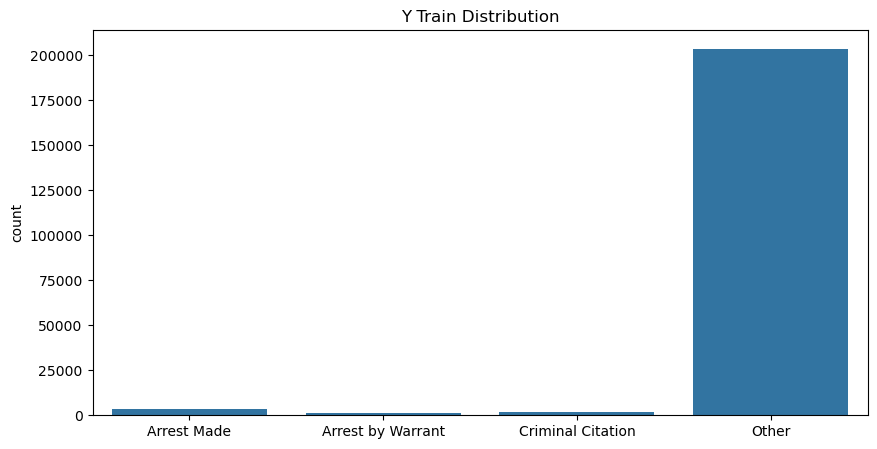

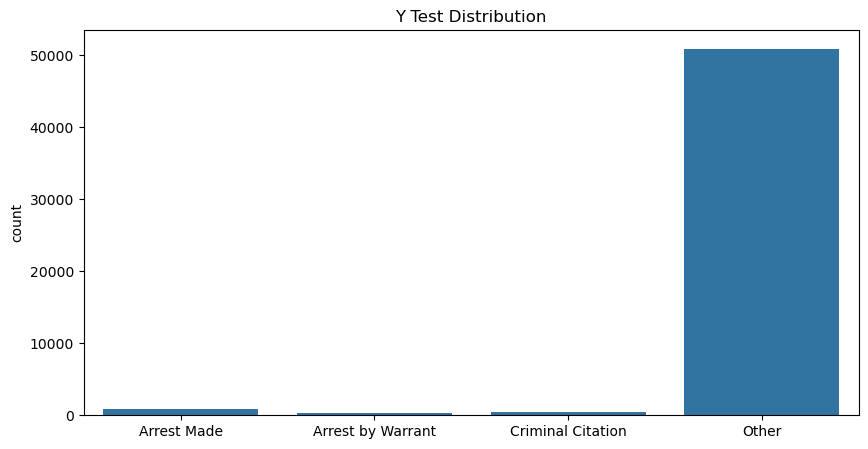

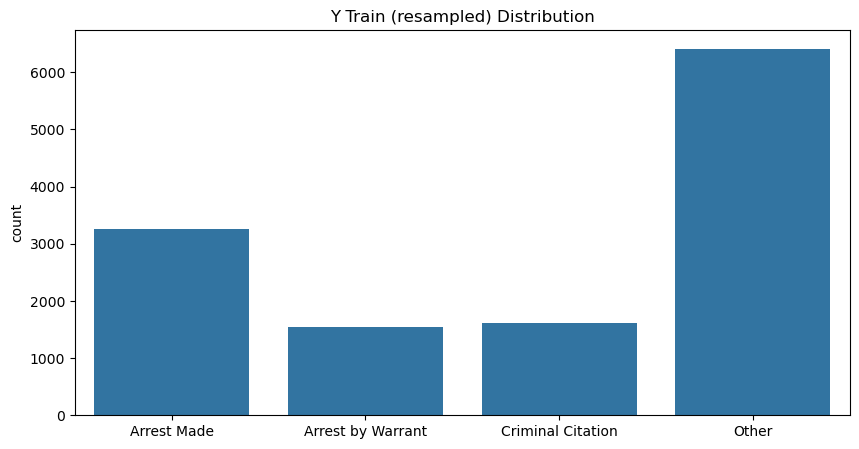

In [42]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [56]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [59]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [60]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00       813
Arrest by Warrant       0.00      0.00      0.00       384
Criminal Citation       0.00      0.00      0.00       406
            Other       0.97      1.00      0.98     50941

         accuracy                           0.97     52544
        macro avg       0.24      0.25      0.25     52544
     weighted avg       0.94      0.97      0.95     52544



### Logistic Regression

In [62]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [63]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [64]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.12      0.60      0.19       813
Arrest by Warrant       0.29      0.57      0.38       384
Criminal Citation       0.11      0.42      0.17       406
            Other       0.99      0.89      0.94     50941

         accuracy                           0.88     52544
        macro avg       0.38      0.62      0.42     52544
     weighted avg       0.96      0.88      0.92     52544



#### Hyperparameter Tuning

In [67]:
grid_search_scoring_method = 'f1_macro'

In [68]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Initialize Grid Search
# make sure n_jobs is reasonable so my machine doesn't run out of memory
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=3, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=3, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [69]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 1}
Best Score (f1_macro): 0.5353


In [70]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2022/best_logistic_regression.pkl']

In [71]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [72]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.57      0.24      0.34       813
Arrest by Warrant       0.66      0.51      0.57       384
Criminal Citation       0.45      0.21      0.29       406
            Other       0.98      0.99      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.66      0.49      0.55     52544
     weighted avg       0.97      0.97      0.97     52544



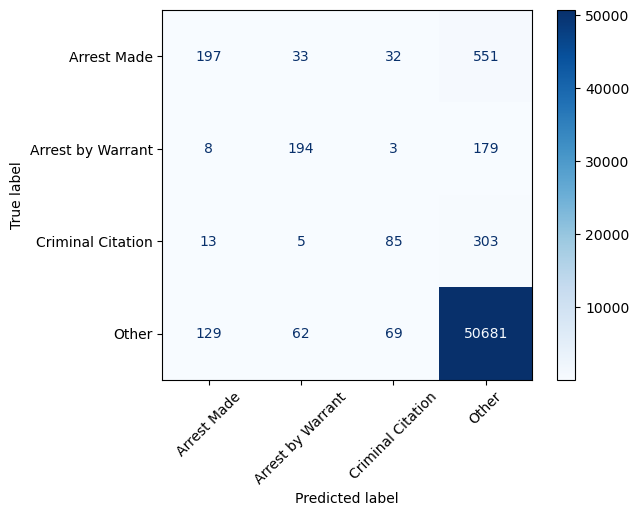

In [74]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [76]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [78]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [82]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                         Feature  Importance  \
205                             CALLTYPE_CODE_6M    0.004980   
204                             CALLTYPE_CODE_6F    0.002728   
112                          CALLTYPE_CODE_23152    0.002411   
64                           CALLTYPE_CODE_11300    0.002379   
49                          CALLTYPE_CODE_10851R    0.001047   
85                           CALLTYPE_CODE_12020    0.000983   
58                            CALLTYPE_CODE_1095    0.000825   
80                            CALLTYPE_CODE_1195    0.000793   
72                           CALLTYPE_CODE_11550    0.000761   
119                            CALLTYPE_CODE_242    0.000666   
231                           CALLTYPE_CODE_DVRO    0.000634   
87                           CALLTYPE_CODE_12025    0.000634   
91                             CALLTYPE_CODE_148    0.000571   
69                           CALLTYPE_CODE_11377    0.000571   
66                           CALLTYPE_CO

In [83]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                    Display Name  Coefficient
107                 Call Type: PARKING VIOLATION    -0.350764
49           Call Type: RECOVERED STOLEN VEHICLE     0.342757
13                     Call Type: ALARM, AUDIBLE    -0.340539
231     Call Type: VIOLATION OF PROTECTIVE ORDER     0.294487
47                     Call Type: STOLEN VEHICLE     0.270605
153                Call Type: DISTURBANCE, MUSIC    -0.265859
212                 Call Type: UNK TYPE 911 CALL    -0.254405
112                   Call Type: MISDEMEANOR DUI     0.232046
0                                       PRIORITY    -0.217825
146               Call Type: DISTURBANCE, FAMILY     0.198367
185                Call Type: MALICIOUS MISCHIEF     0.190766
165                    Call Type: BURGLARY (460)     0.184184
63                     Call Type: TRAFFIC HAZARD    -0.183546
76   Call Type: VEHICLE ACCIDENT, MINOR INJURIES    -0.175668
16                      Call Type: ALARM, SILENT 

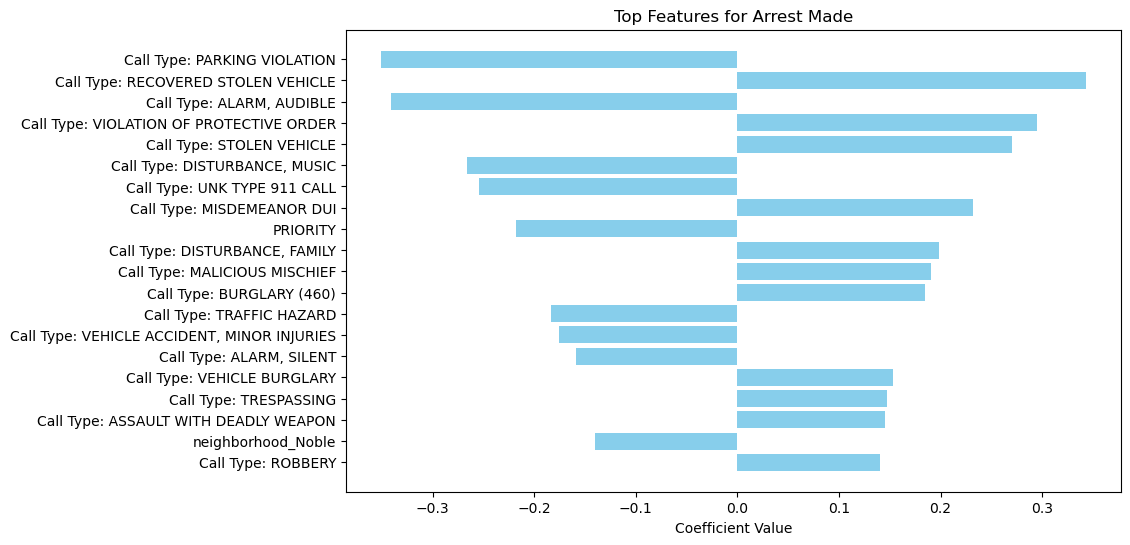

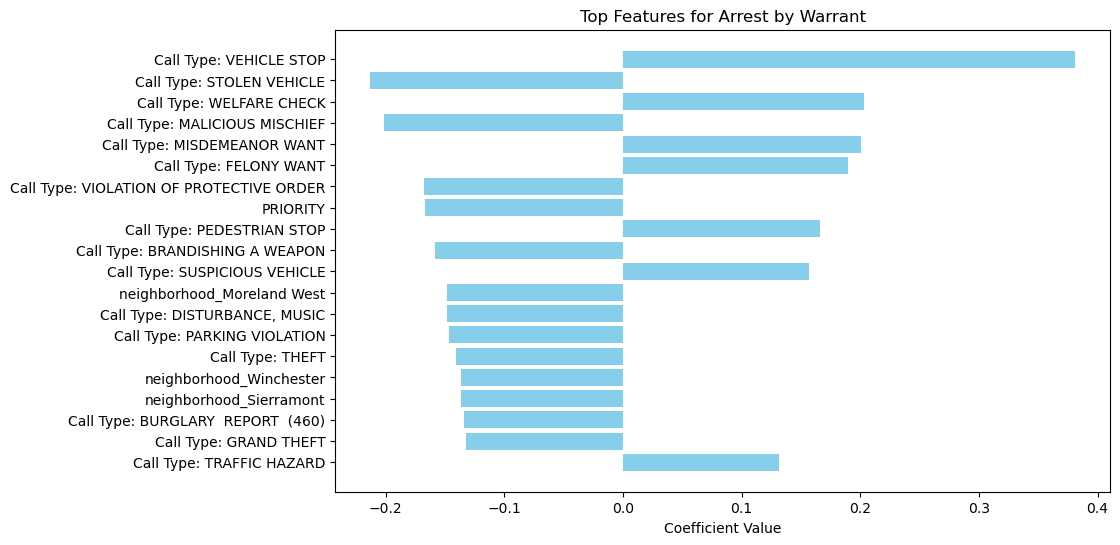

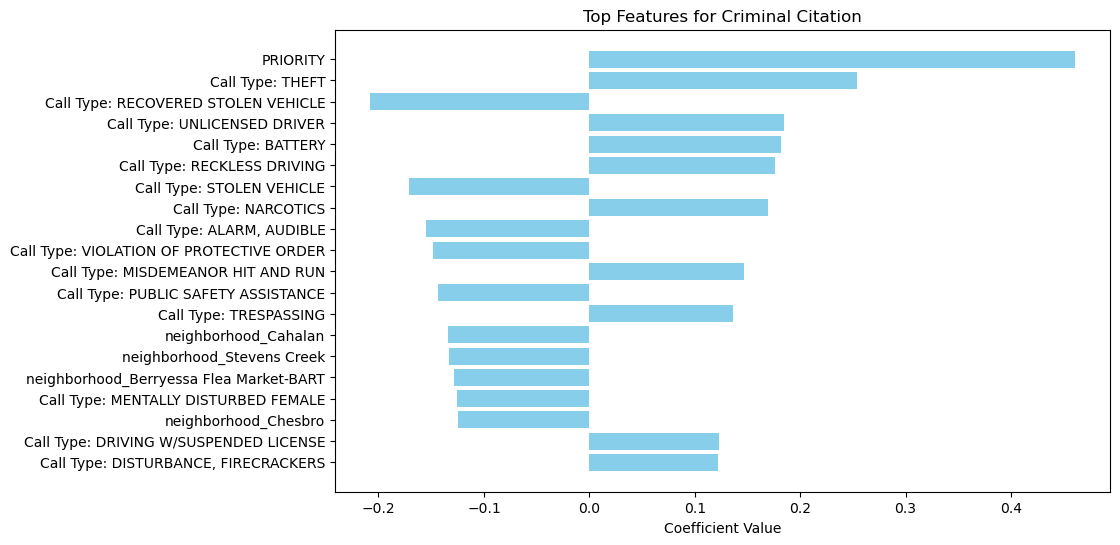

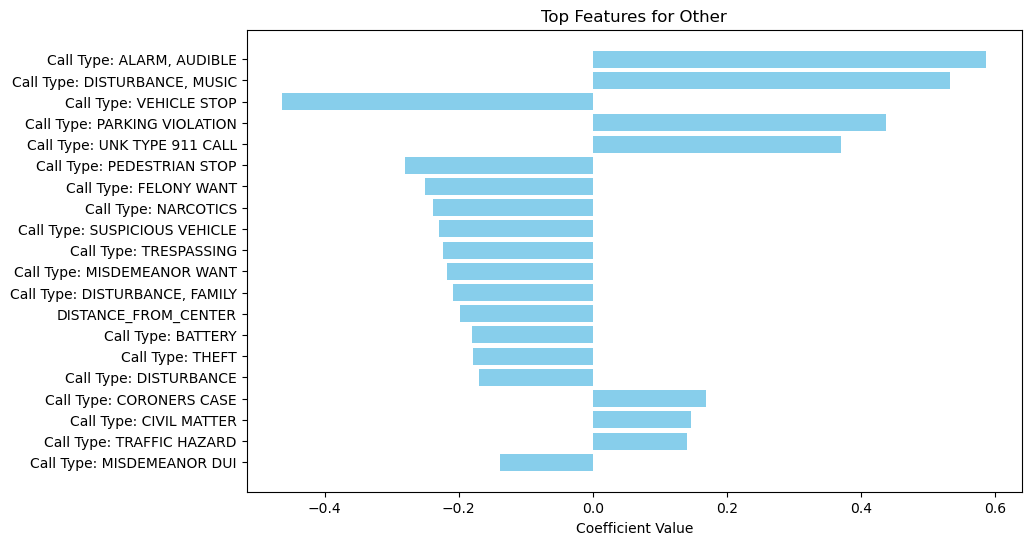

In [84]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [86]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [87]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.52      0.25      0.34       813
Arrest by Warrant       0.55      0.45      0.50       384
Criminal Citation       0.38      0.23      0.28       406
            Other       0.98      0.99      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.61      0.48      0.53     52544
     weighted avg       0.97      0.97      0.97     52544



#### Hyperparameter Tuning and Cross Validation

In [89]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=5,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 60}
Best Score (f1_macro): 0.51


In [90]:
best_rf = grid_rf.best_estimator_

In [91]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2022/best_random_forest.pkl']

In [92]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [93]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.52      0.25      0.33       813
Arrest by Warrant       0.55      0.45      0.49       384
Criminal Citation       0.37      0.22      0.27       406
            Other       0.98      0.99      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.60      0.48      0.52     52544
     weighted avg       0.96      0.97      0.97     52544



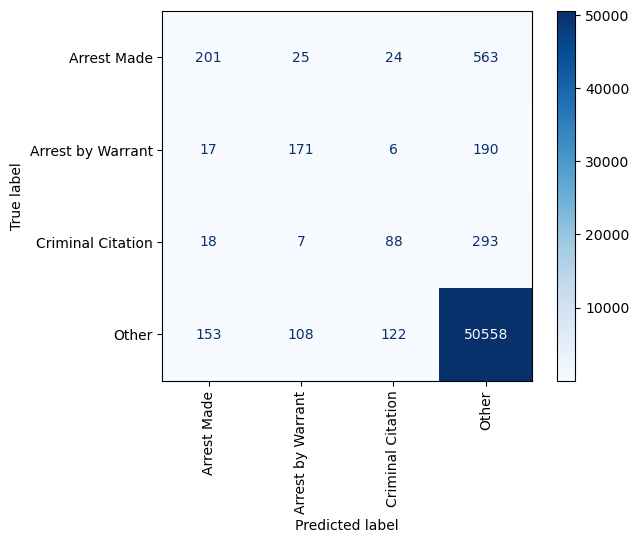

In [94]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

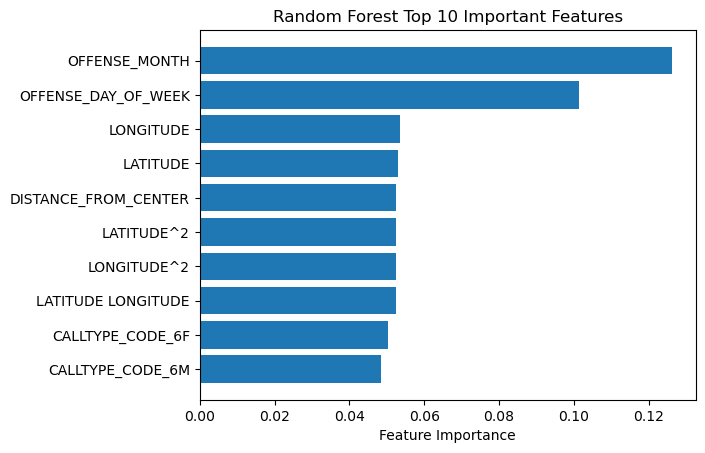

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Top 10 Important Features')
plt.show()

### Multilayer Perceptron Model

In [98]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [99]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [103]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [105]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9679 - loss: 0.1601 - val_accuracy: 0.9722 - val_loss: 0.1112
Epoch 2/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9729 - loss: 0.1131 - val_accuracy: 0.9725 - val_loss: 0.1106
Epoch 3/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9732 - loss: 0.1102 - val_accuracy: 0.9698 - val_loss: 0.1108
Epoch 4/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9733 - loss: 0.1068 - val_accuracy: 0.9706 - val_loss: 0.1110
Epoch 5/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9731 - loss: 0.1050 - val_accuracy: 0.9725 - val_loss: 0.1105
Epoch 6/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9735 - loss: 0.1031 - val_accuracy: 0.9730 - val_loss: 0.1139
Epoch 7/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9743 - loss: 0.0998 - val_accuracy: 0.9720 - val_loss: 0.1151
Epoch 8/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9741 - loss: 0.0982 - 

In [106]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2022/mlp_model.pkl']

In [107]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [108]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1642/1642 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - accuracy: 0.9730 - loss: 0.1138
Test Accuracy: 0.9731


In [109]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1642/1642 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.65      0.15      0.24       813
Arrest by Warrant       0.66      0.43      0.52       384
Criminal Citation       0.43      0.17      0.25       406
            Other       0.98      1.00      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.68      0.44      0.50     52544
     weighted avg       0.97      0.97      0.97     52544



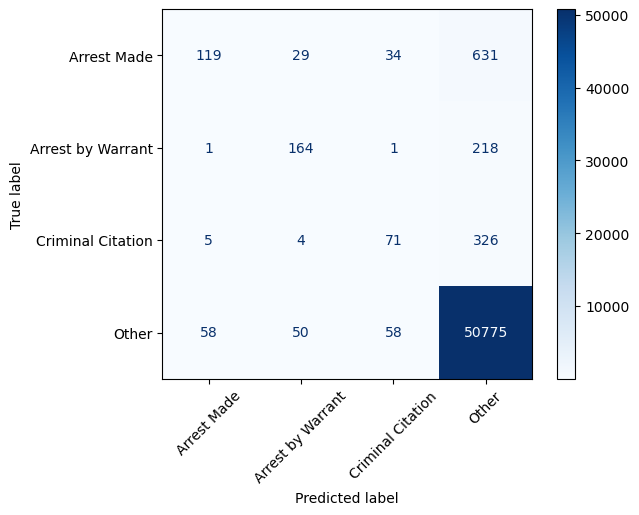

In [110]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [113]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-04 13:17:52,612] A new study created in memory with name: no-name-f74b0ec6-6426-4db0-9be1-b79d1953364e
[I 2024-10-04 13:18:28,849] Trial 0 finished with value: 0.6300029748336935 and parameters: {'n_estimators': 497, 'learning_rate': 0.03766182261318414, 'max_depth': 11, 'subsample': 0.9993241626641536, 'colsample_bytree': 0.6850747060644617, 'gamma': 5.875182520143346e-07, 'reg_alpha': 2.2525991581985784e-06, 'reg_lambda': 0.0022782710540506725}. Best is trial 0 with value: 0.6300029748336935.
[I 2024-10-04 13:18:36,680] Trial 1 finished with value: 0.6278755101316912 and parameters: {'n_estimators': 104, 'learning_rate': 0.19307760685119196, 'max_depth': 9, 'subsample': 0.7887949019396411, 'colsample_bytree': 0.9811843360110274, 'gamma': 0.013599966243931134, 'reg_alpha': 6.605294906394107e-06, 'reg_lambda': 0.019439448426987475}. Best is trial 0 with value: 0.6300029748336935.
[I 2024-10-04 13:18:43,786] Trial 2 finished with value: 0.6421082571474716 and parameters: {'n_

Actual runtime: 353.07 seconds (5.88 minutes)
Best parameters found:  {'n_estimators': 354, 'learning_rate': 0.05977236557413425, 'max_depth': 4, 'subsample': 0.8253177974859189, 'colsample_bytree': 0.9394785356094102, 'gamma': 2.6236160287999094e-06, 'reg_alpha': 2.985503965725151e-05, 'reg_lambda': 1.9748194496797787e-07}
Best F1 macro score:  0.646589801575186


In [114]:
# Train the final model with the best parameters:
best_params = study.best_params
best_model = XGBClassifier(**best_params, eval_metric='logloss')
best_model.fit(X_train, y_train)
xgb_1_model = best_model
xgb_1_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9394785356094102, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=2.6236160287999094e-06, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05977236557413425, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=354, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [115]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.67      0.24      0.35       813
Arrest by Warrant       0.67      0.51      0.58       384
Criminal Citation       0.47      0.16      0.24       406
            Other       0.98      1.00      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.70      0.48      0.54     52544
     weighted avg       0.97      0.97      0.97     52544



In [116]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2022/xgb_model.pkl']

In [117]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [119]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [120]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.5462613143494697
RF F1: 0.5212598503961184
XGB F1: 0.5393918636362989


In [121]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

#### Stacking #1

In [123]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=5)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9394785356094102,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              ev...
                                              learning_rate=0.05977236557413425,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=354, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(), n_jobs=5)

In [124]:
joblib.dump(stacking_clf, f"models/{year}/stacking_1.pkl") 

['models/2022/stacking_1.pkl']

In [125]:
stacking_clf = joblib.load(f"models/{year}/stacking_1.pkl")

In [126]:
y_pred_stacking_1 = stacking_clf.predict(X_test)
stack_1_accuracy = accuracy_score(y_test, y_pred_stacking_1)
stack_1_recall = recall_score(y_test, y_pred_stacking_1, average='macro')
stack_1_prec = precision_score(y_test, y_pred_stacking_1, average='macro')
stack_1_f1 = f1_score(y_test, y_pred_stacking_1, average='macro')
print(f"Stacking Classifier F1 Score: {stack_1_f1}")

Stacking Classifier F1 Score: 0.5569493714576096


#### Stacking #2

In [128]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=5)
stacking_clf_2.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=60)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9394785356094102,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              ev...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=5)

In [129]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2022/stacking_2.pkl']

In [130]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [131]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.5564667705133489


## Results

In [133]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Stack 1', 'Stack 2'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.969492,0.250000,0.242373,0.246127
Logistic Regression,0.973603,0.487944,0.664337,0.546261
Random Forest,0.970958,0.475444,0.603236,0.521260
MLP,0.973070,0.436268,0.681137,0.498714
XGB,0.974460,0.476297,0.696873,0.539392
Stack 1,0.974783,0.489508,0.694454,0.556949
Stack 2,0.974307,0.495083,0.675692,0.556467


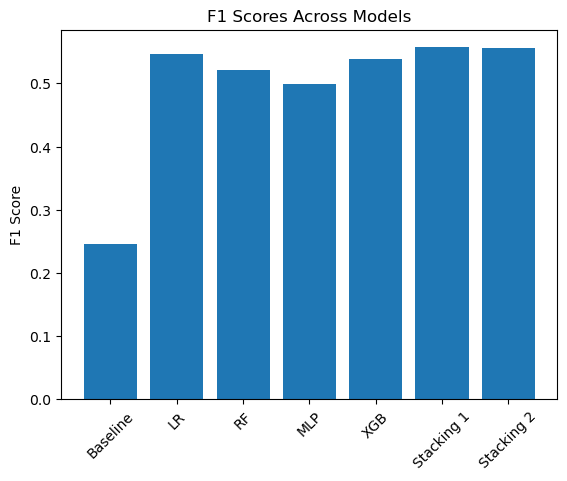

In [134]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Stacking 1', 'Stacking 2']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Compare with the All-Year Models

In [136]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [137]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

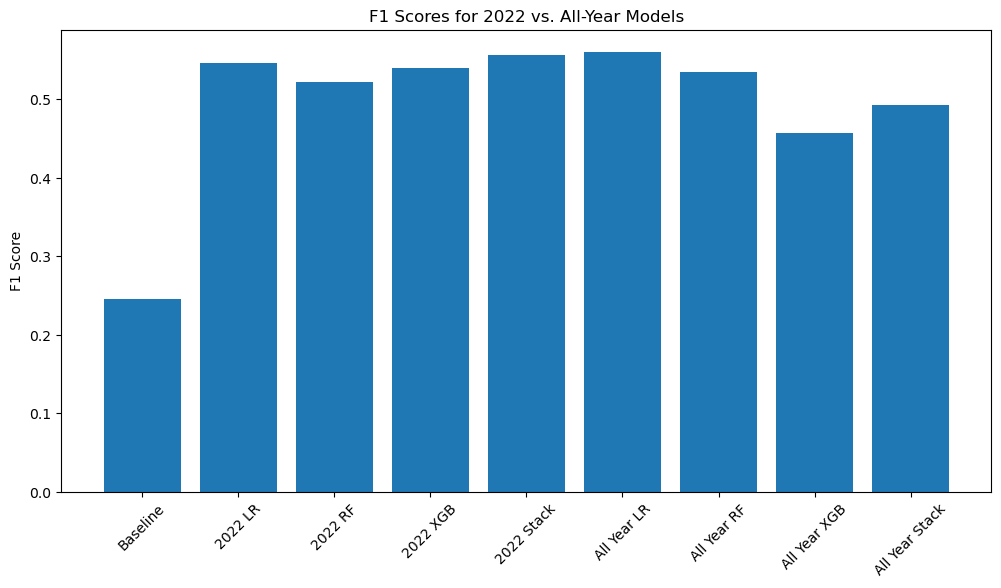

In [138]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()